In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [2]:
import matplotlib
matplotlib.use("Agg")

/home/aiteam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [3]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [4]:
# Load images
imagePaths = sorted(list(paths.list_images('./pose_dataset/train_set')))
random.seed(42)
random.shuffle(imagePaths)

In [5]:
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

[INFO] data matrix: 2034 images (439.34MB)
[INFO] class labels:
1. bending
2. crouching
3. h
4. n
5. others
6. standing


In [7]:
def print_label_details(labels):

    print(len(labels))

    count_h = 0
    count_n = 0
    count_bending = 0
    count_couching = 0
    count_others = 0
    count_standing = 0
    for label in labels:
        if label[0] == 1:
            count_bending += 1
        if label[1] == 1:
            count_couching += 1
        if label[2] == 1:
            count_h += 1
        if label[3] == 1:
            count_n += 1
        if label[4] == 1:
            count_others += 1
        if label[5] == 1:
            count_standing += 1

    print("bending: {}\ncrouching: {}\n_h: {}\n_n: {} \nothers: {}\nstanding: {}".format(count_bending, count_couching, count_h, count_n, count_others, count_standing))

print_label_details(labels)

2034
bending: 540
crouching: 414
_h: 1001
_n: 1033 
others: 540
standing: 540


In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0, random_state=42)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
    finalAct="sigmoid")

# initialize the optimizer (SGD is sufficient)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
#     validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/75


ResourceExhaustedError: OOM when allocating tensor of shape [8192,1024] and type float
	 [[node training/Adam/zeros_20 (defined at /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:702)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [8192,1024] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training/Adam/zeros_20', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aiteam/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/aiteam/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aiteam/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/aiteam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-43d5d8f7e881>", line 36, in <module>
    epochs=EPOCHS, verbose=1)
  File "/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training_generator.py", line 40, in fit_generator
    model._make_train_function()
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/optimizers.py", line 487, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/usr/local/lib/python3.6/site-packages/keras/optimizers.py", line 487, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1563, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2979, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [8192,1024] and type float
	 [[node training/Adam/zeros_20 (defined at /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:702)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [8192,1024] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [11]:
# save the model to disk
print("[INFO] serializing network...")
model.save('pose_multi_labels.h5')

[INFO] serializing network...


In [12]:
print("[INFO] serializing label binarizer...")
f = open('mlb.pickle', "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing label binarizer...


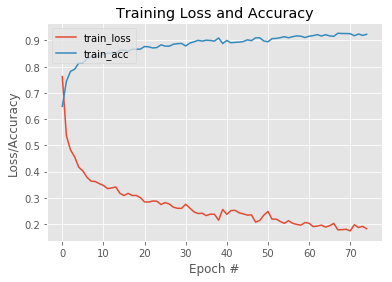

In [14]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('plot.jpg')

# Testing

In [15]:
# Load images
test_image_paths = sorted(list(paths.list_images('./dataset/test_set')))
random.seed(42)
random.shuffle(test_image_paths)
print(len(test_image_paths))

225


In [16]:
test_data = []
test_labels = []

# loop over the input images
for test_image_path in test_image_paths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(test_image_path)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    test_data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = test_image_path.split(os.path.sep)[-2].split("_")
    test_labels.append(l)
    
# scale the raw pixel intensities to the range [0, 1]
test_data = np.array(test_data, dtype="float") / 255.0
test_labels = np.array(test_labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(test_image_paths), test_data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
test_mlb = MultiLabelBinarizer()
test_labels = test_mlb.fit_transform(test_labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(test_mlb.classes_):
    print("{}. {}".format(i + 1, label))
    
print_label_details(test_labels)

[INFO] data matrix: 225 images (48.60MB)
[INFO] class labels:
1. bending
2. crouching
3. h
4. n
5. others
6. standing
225
bending: 60
crouching: 45
_h: 111
_n: 114 
others: 60
standing: 60


In [17]:
from keras.models import load_model

# construct the image generator
test_generator = ImageDataGenerator().flow(test_data, test_labels, batch_size=BS)
steps_test = test_generator.n / BS

# load model
_model = load_model('pose_multi_labels.h5')

# evaluate model
print(_model.evaluate_generator(test_generator, steps=steps_test))

[0.229553544388877, 0.9103703731960721]


In [ ]:
print(H)

In [ ]:
# Predict the classes for all images in the test-set.
y_pred = _model.predict_generator(test_generator,
                                 steps=steps_test)
print(y_pred)

In [ ]:
np.set_printoptions(suppress=True)
print(y_pred)
print(test_labels)
mlb = pickle.loads(open('mlb.pickle', "rb").read())
new_pred = []
count = 0
for i, pred in enumerate(y_pred):
    idxs = np.argsort(pred)[::-1][:2]
    label = np.argsort(test_labels[i])[::-1][:2]
    new_pred.append(idxs)
    pred_label = '{}_{}'.format(mlb.classes_[idxs[0]], mlb.classes_[idxs[1]])
    true_label = '{}_{}'.format(mlb.classes_[label[0]], mlb.classes_[label[1]])
    print('pre: {} - true: {}'.format(pred_label, true_label))
    if pred_label == true_label:
        count += 1
print(count)
print(len(new_pred))
print(count/len(new_pred) * 100)
    